In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

# 1

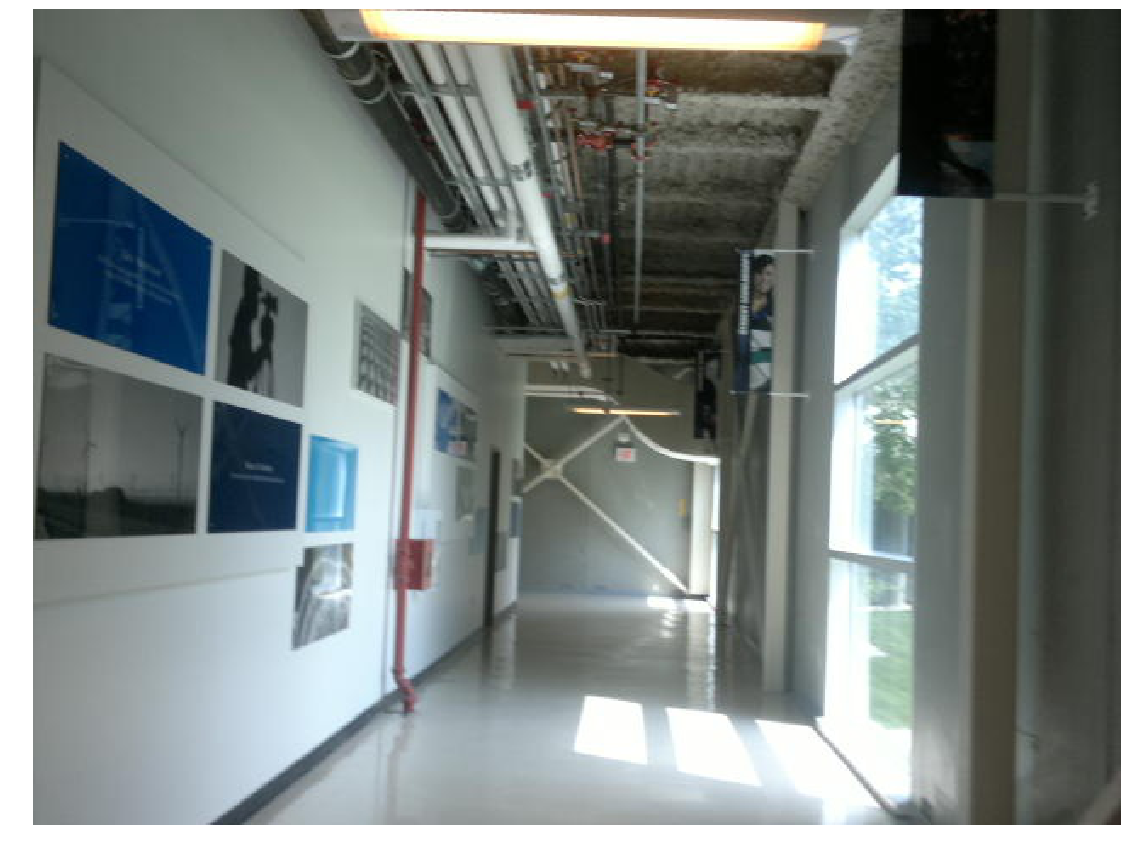

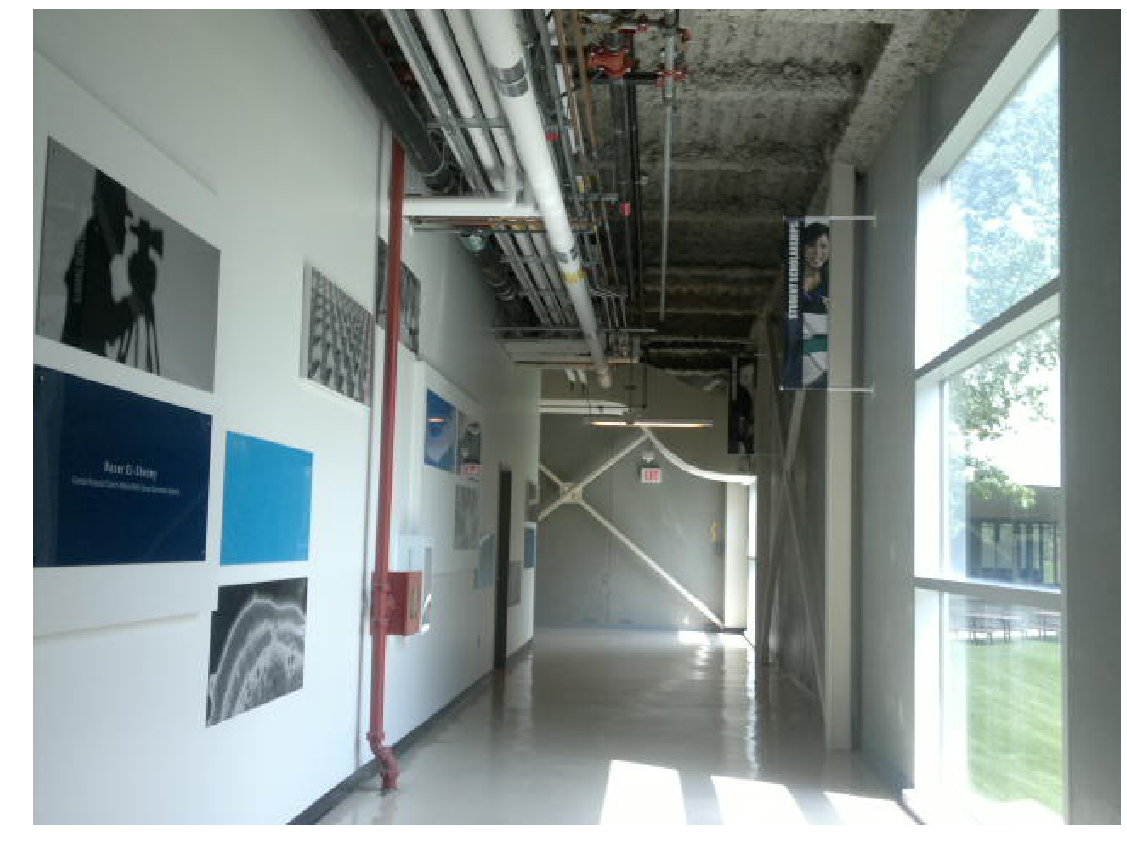

In [6]:
def show_img(img):
    plt.figure(figsize=(30,15))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

img1 = imread('4-image.jpg')
img2 = imread('4-image-second.jpg')

show_img(img1)
show_img(img2)

In [8]:
# Focal length:
fc = [ 719.302047058490760, 718.392548175289110 ]

# Principal point:
cc = [ 334.631234942930060, 256.166677783686790 ]

# Skew coefficient:
alpha_c = 0.000000000000000

# Distortion coefficients:
kc = [ 0.166329582926249, -0.520179332215331, 0.000740948247014, -0.002307272386086, 0.000000000000000 ]

# Focal length uncertainty:
fc_error = [ 21.589238769417289, 20.815686366812162 ]

# Principal point uncertainty:
cc_error = [ 4.538120743575024, 9.598915760688465 ]

# Skew coefficient uncertainty:
alpha_c_error = 0.000000000000000

# Distortion coefficients uncertainty:
kc_error = [ 0.028190787769788, 0.154098055417021, 0.003003250194962, 0.002928913420256, 0.000000000000000 ]

# Image size:
nx = 640
ny = 480

In [180]:
K = np.array([
    [fc[0], alpha_c, cc[0]],
    [0, fc[1], cc[1]],
    [0, 0, 1]
]); K

K_inv = np.linalg.inv(K)

In [293]:
orb = cv.ORB_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)[:18]

pts1 = []
pts2 = []

for m in matches:
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
    
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)    

# OpenCV functions
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)
E, mask = cv.findEssentialMat(pts1, pts2)

print(F, '\n\n', E)

def get_error(F, E):
    error_f = 0
    error_e = 0
    for i in range(len(pts1)):
        a = np.array([pts1[i][0], pts1[i][1], 1])
        b = np.array([pts2[i][0], pts2[i][1], 1])
        error_f += b.T @ F @ a
        error_e += K_inv @ b.T @ E @ (K_inv @ a)
    print('Average fundamental matrix error, should be zero ', error_f / len(pts1))
    print('Average essential matrix error, should be zero ', error_e / len(pts1))

get_error(F, E)

[[ 6.32308784e-06 -1.99699247e-04  6.34583111e-02]
 [ 1.98571911e-04  3.47410751e-06 -7.26627626e-02]
 [-7.11717916e-02  7.48352570e-02  1.00000000e+00]] 

 [[ 5.01486218e-06  1.53387077e-03 -4.64693191e-01]
 [-1.48411254e-03 -8.27079455e-05  5.32970762e-01]
 [ 4.67669933e-01 -5.30360889e-01 -6.07958189e-05]]
Average fundamental matrix error, should be zero  0.0032974590238589053
Average essential matrix error, should be zero  0.0027849766275243517


In [294]:
# Getto fundamentalist matrixi

A = np.array([[l[0] * r[0], l[1] * r[0], r[0], l[0] * r[1], l[1] * r[1], r[1], l[0], l[1], 1] for l, r in zip(pts1, pts2)])
u, s, v = np.linalg.svd(A)
f = v[-1].reshape(3,3).T
u, s, v = np.linalg.svd(f)
f = u @ np.diag(s) @ v
print('Fundamental matrix', f)


# Get Essential matrix
e_pts1 = [K_inv @ np.array([x, y, 1]) for (x, y) in pts1]
e_pts2 = [K_inv @ np.array([x, y, 1]) for (x, y) in pts2]

# I think this should be correct but it produces big errors ??????????????????????????
# A = np.array([[l[0] * r[0], l[0] * r[1], l[2] * r[2], l[1] * r[0], l[1] * r[1], l[1] * r[2], l[2] * r[0], l[2] * r[1], l[2] * r[2]] for l, r in zip(e_pts1, e_pts2)])

A = np.array([[l[0] * r[0], l[1] * r[0], r[0], l[0] * r[1], l[1] * r[1], r[1], l[0], l[1], 1] for l, r in zip(e_pts1, e_pts2)])

u, s, v = np.linalg.svd(A)
e = v[-1].reshape(3,3).T
u, s, v = np.linalg.svd(e)
e = u @ np.diag(s) @ v
print('Essential matrix', e)

get_error(f, e)

Fundamental matrix [[-3.16610277e-06 -3.69429782e-05  1.57649461e-02]
 [ 3.41639049e-05 -1.12801873e-06 -6.74918736e-03]
 [-1.19052254e-02  8.61150112e-03 -9.99744978e-01]]
Essential matrix [[ 4.92693956e-03  6.98895387e-01 -5.88618342e-02]
 [-7.10294583e-01  1.36938929e-02  3.27777208e-02]
 [ 4.44397618e-02 -1.73377402e-02 -6.78833533e-04]]
Average fundamental matrix error, should be zero  0.0859582584020387
Average essential matrix error, should be zero  0.000759754288161641


In [401]:
# Another way of calculating essential matrix ?
get_error(F, K.T @ F @ K)

Average fundamental matrix error, should be zero  0.0032974590238589053
Average essential matrix error, should be zero  0.0032974590238601265


In [402]:
# 1st and 2nd singular values should be the same and third should be about 0, seems okay
print(np.linalg.svd(E)[1])
np.linalg.svd(e)[1]

[7.07106781e-01 7.07106781e-01 4.24733575e-16]


array([7.13572469e-01, 7.00581424e-01, 1.05134713e-05])

# 2

In [308]:
# Focal length:
fc = [ 585.850107917267790 , 586.003198722303180 ]

# Principal point:
cc = [ 664.903569991381570 , 498.409524449186850 ]

# Skew coefficient:
alpha_c = 0.000000000000000

# Distortion coefficients:
kc = np.array([ -0.159950393345315 , 0.000000000000000 , -0.000685869015729 , -0.004896132860374 , 0.000000000000000 ])

# Focal length uncertainty:
fc_error = [ 8.710017825595292 , 8.939613454740497 ]

# Principal point uncertainty:
cc_error = [ 5.809944557431711 , 7.463027311611222 ]

# Skew coefficient uncertainty:
alpha_c_error = 0.000000000000000,

# Distortion coefficients uncertainty:
kc_error = [ 0.005683206262503 , 0.000000000000000 , 0.002055303935265 , 0.001210028314335 , 0.000000000000000 ]

# Image size:
nx = 1280
ny = 960

K_2 = np.array([
    [fc[0], alpha_c, cc[0]],
    [0, fc[1], cc[1]],
    [0, 0, 1]
]); K_2


array([[585.85010792,   0.        , 664.90356999],
       [  0.        , 586.00319872, 498.40952445],
       [  0.        ,   0.        ,   1.        ]])

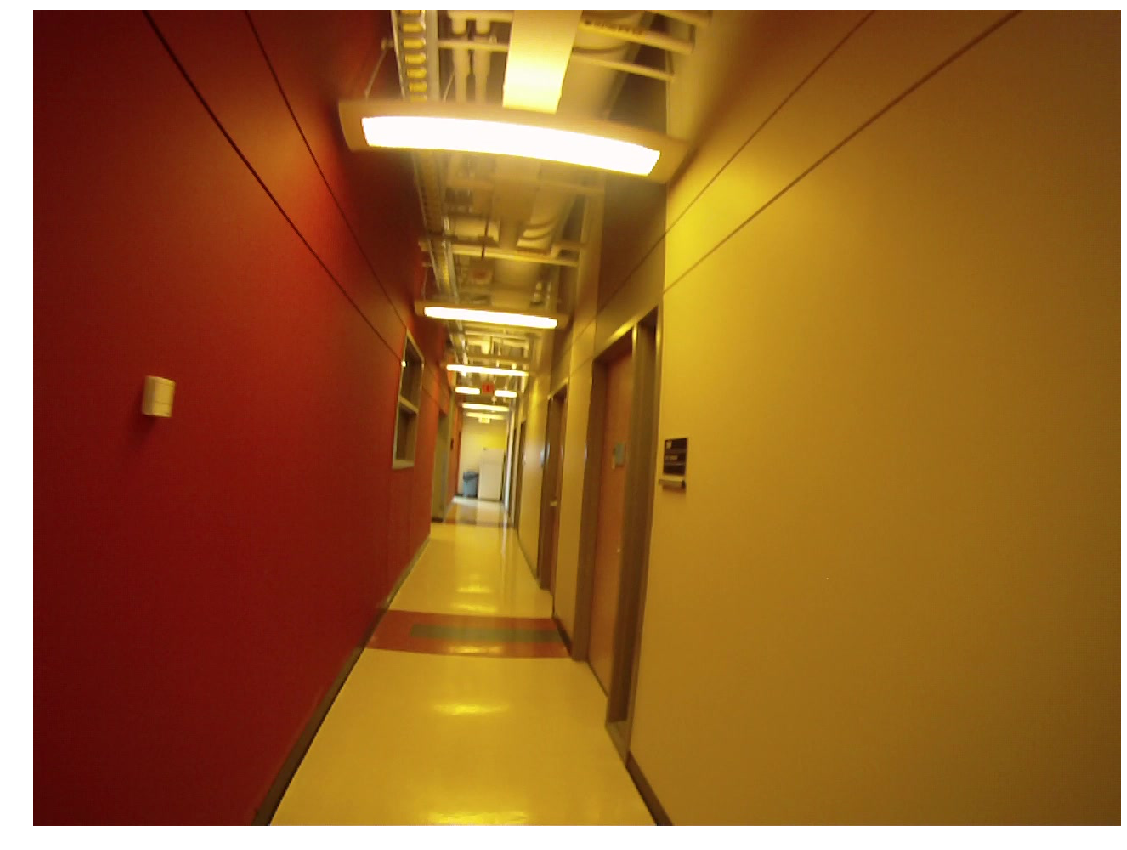

In [380]:
corr = imread('3-Corridor1.jpg')

show_img(corr)

In [391]:
new_camera, _ = cv.getOptimalNewCameraMatrix(K_2, np.abs(kc), (nx, ny), 0)

m_x, m_y = cv.initUndistortRectifyMap(K_2, kc, None, new_camera, (nx, ny), 5)

new_corr = cv.remap(corr, m_x, m_y, cv.INTER_LINEAR)

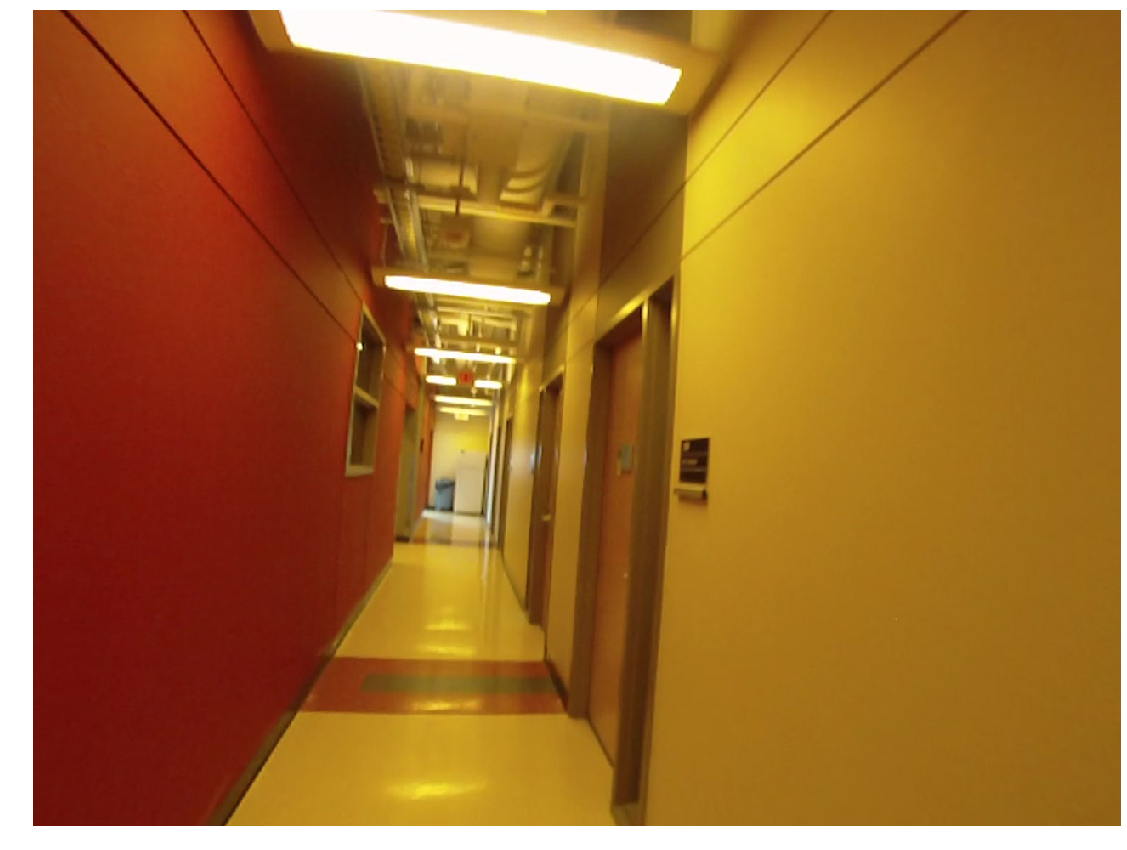

In [392]:
show_img(new_corr)

In [393]:
new_camera

array([[708.80126953,   0.        , 667.62465808],
       [  0.        , 708.21356201, 497.48029492],
       [  0.        ,   0.        ,   1.        ]])

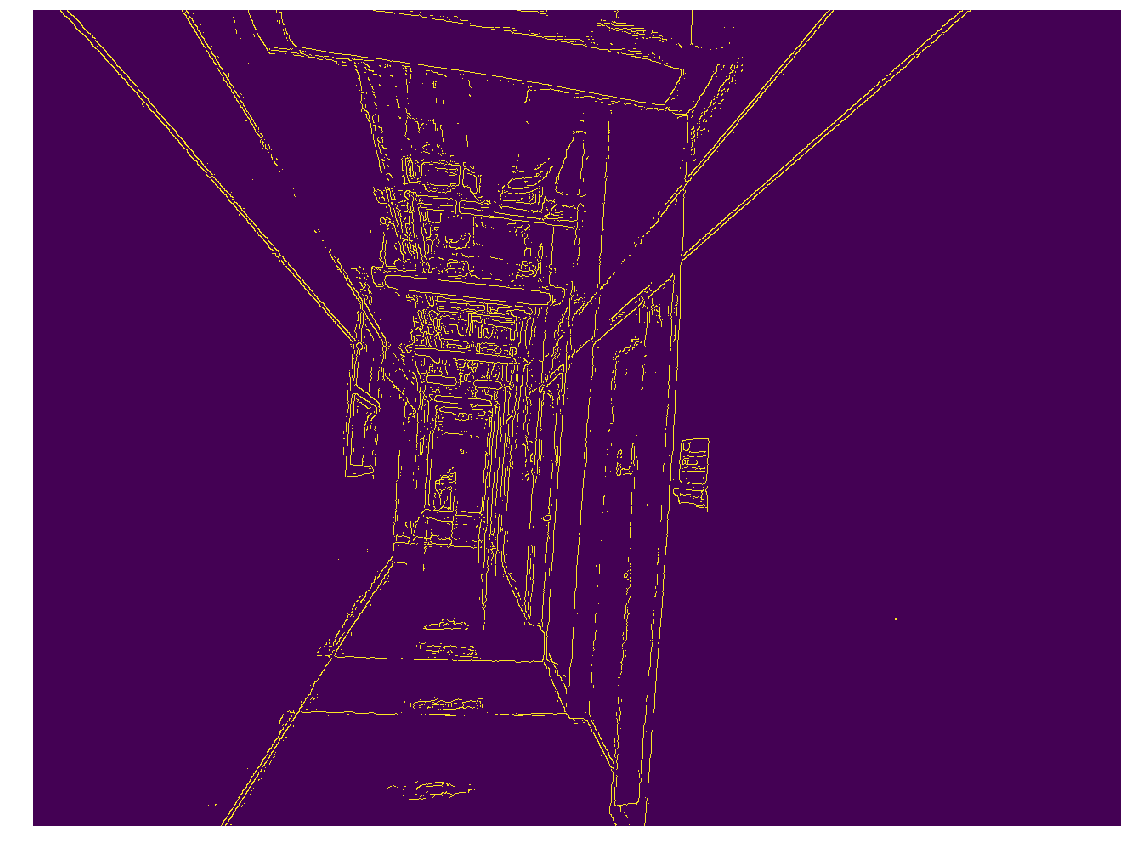

Hough lines


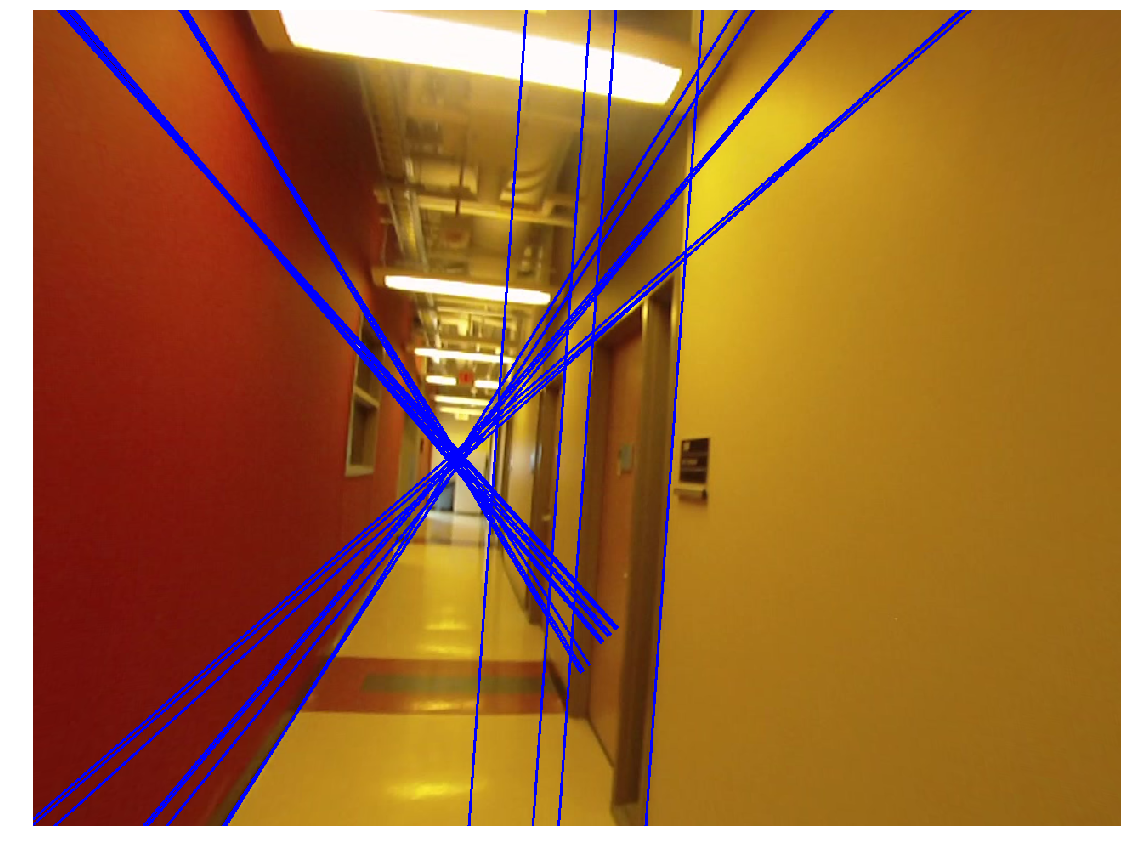

Vanishing point


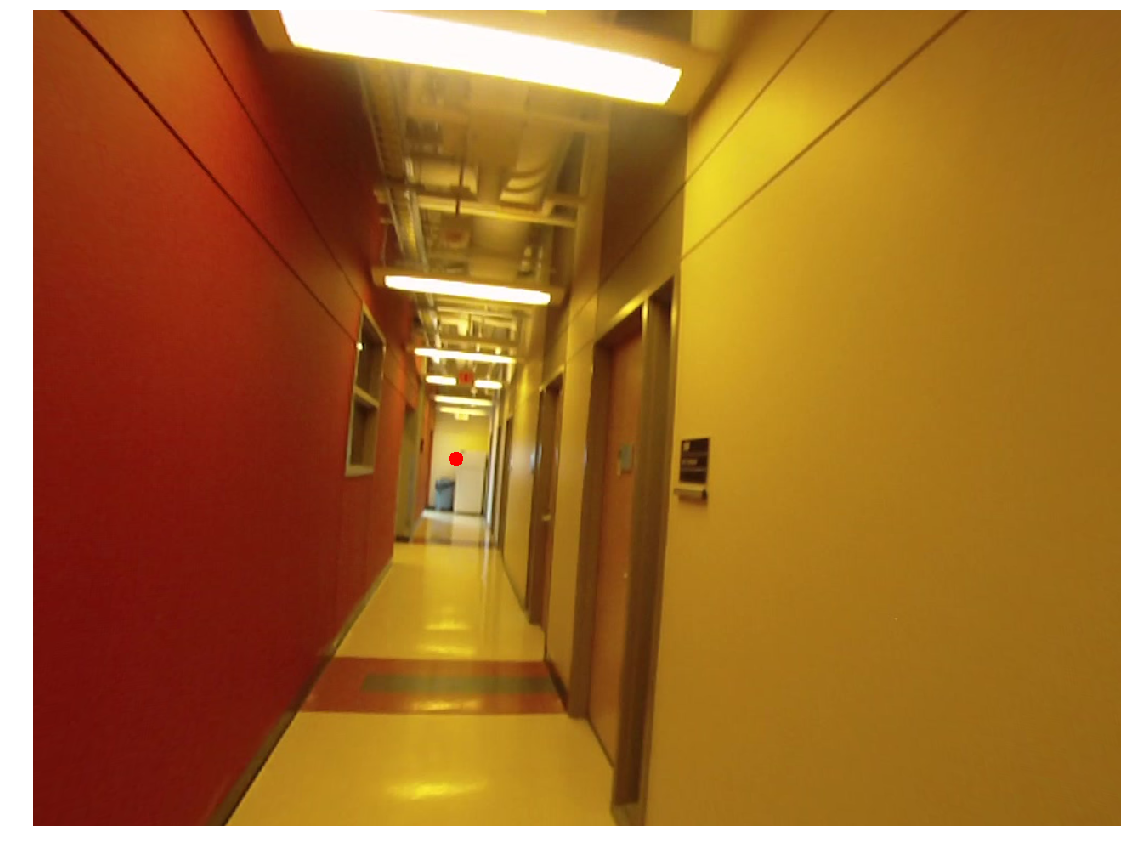

In [399]:
from itertools import starmap
from copy import deepcopy

corr1 = deepcopy(new_corr)
line_master = deepcopy(new_corr)

gray = cv2.cvtColor(corr1, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 35, 35, True)
show_img(edges)

lines = cv2.HoughLines(edges,1,np.pi/180,200)

h_lines = []

for l in lines:
    rho, theta = l[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    h_lines.append(((x1,y1),(x2,y2)))
    cv2.line(line_master,(x1,y1),(x2,y2),(0,0,255),2)

def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def l_intersect(line1, line2):
    x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    div = det(x_diff, y_diff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, x_diff) / div
    y = det(d, y_diff) / div

    return x, y

def f_intersections(lines):
    intersections = []
    for i, line_1 in enumerate(lines):
        for line_2 in lines[i + 1:]:
            if not line_1 == line_2:
                intersection = l_intersect(line_1, line_2)
                if intersection:  
                    intersections.append(intersection)

    return intersections

import itertools

intersections = f_intersections(h_lines)
grid_size = 5

image_height, image_width = corr1.shape[:2]

grid_rows = (image_height // grid_size) + 1
grid_columns = (image_width // grid_size) + 1

max_intersections = 0
best_cell = (0.0, 0.0)

for i, j in itertools.product(range(grid_columns),range(grid_rows)):
    cell_left = i * grid_size
    cell_right = (i + 1) * grid_size
    cell_bottom = j * grid_size
    cell_top = (j + 1) * grid_size

    current_intersections = 0
    for x, y in intersections:
        if cell_left < x < cell_right and cell_bottom < y < cell_top:
            current_intersections += 1
    if current_intersections > max_intersections:
        max_intersections = current_intersections
        best_cell = ((cell_left + cell_right) / 2, (cell_bottom + cell_top) / 2)

if best_cell[0] != None and best_cell[1] != None:
        rx1 = int(best_cell[0] - grid_size / 2)
        ry1 = int(best_cell[1] - grid_size / 2)
        rx2 = int(best_cell[0] + grid_size / 2)
        ry2 = int(best_cell[1] + grid_size / 2)
        cv2.rectangle(corr1, (rx1, ry1), (rx2, ry2), (255, 0, 0), 10)

print('Hough lines')
show_img(line_master)
print('Vanishing point')
show_img(corr1)




After undistorting the image, the vanishing point appears in the middle of the corridor as it should in an undistorted image. the edge detector does not really see any change, except the lines are now straight instead of curved. And obviously the lines now intersect in the center as well since the vanishing point is there and the lines are proper.